## Experiments with sparse feature GSC (Glasgow Coma Score)- how important might it be?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# import datetime as datetime
import cPickle as pickle
%matplotlib notebook
plt.style.use('ggplot')

In [2]:
# from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier #, RandomForestClassifier, 
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.grid_search import GridSearchCV

### function definitions

In [3]:
def score_printout(X_test, y_test, fittedModel):
    print "AUC-ROC Score of model: ", roc_auc_score(y_test, fittedModel.predict_proba(X_test)[:,1])
    print "Precision Score of model: ", precision_score(y_test, fittedModel.predict(X_test))
    print "Recall Score of model: ", recall_score(y_test, fittedModel.predict(X_test))

In [43]:
def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values)+2)
    width = 0.35   
    plt.barh(range(numFeatures),values)
    ax = plt.subplot(111)
    ax.set_yticks(ind+width)
    ax.set_yticklabels(labels, rotation=0, size=12)
    plt.ylabel('Feature', size=20)
    plt.xlabel('Importance', size=20)
    plt.show()
    
# vertical bar chart:    
#     topN = featuresAndImportances[:numFeatures]
#     labels = [pair[0] for pair in topN]
#     values = [pair[1] for pair in topN]
#     ind = np.arange(len(values))
#     width = 0.35   
#     plt.bar(range(numFeatures), values, width=0.8)
#     ax = plt.subplot(111)
#     ax.set_xticks(ind+width)
#     ax.set_xticklabels(labels, rotation=60, size=12)
#     plt.xlabel('Feature', size=20)
#     plt.ylabel('Importance', size=20)
#     plt.show()

### read in data

In [6]:
# for RRT events
masterdf_rrt = pickle.load(open('RRT_modeling_table_13hr_raw.p', 'rb'))
# for non-rrt events
masterdf_nonrrt = pickle.load(open('NonRRT_modeling_table_13hr_raw.p', 'rb'))

### Look at summary statistics for numeric columns for rrt & non-rrt tables (35 cols)

In [7]:
masterdf_rrt.columns

Index([u'rrt_ce_id', u'encntr_id', u'event_end_dt_tm', u'timestart',
       u'timeend', u'age', u'sex', u'obese', u'smoker', u'prev_rrt', u'on_iv',
       u'bu-nal', u'DBP_mean', u'DBP_recent', u'SBP_mean', u'SBP_recent',
       u'HR_mean', u'HR_recent', u'MAP_mean', u'MAP_recent', u'temp_mean',
       u'temp_recent', u'SPO2_mean', u'SPO2_recent', u'RR_mean', u'RR_recent',
       u'pulse_mean', u'pulse_recent', u'CO2_mean', u'CO2_recent', u'GCS_mean',
       u'GCS_recent', u'anticoagulants', u'narcotics', u'narc-ans',
       u'antipsychotics', u'chemo', u'dialysis', u'race', u'rrt_reason'],
      dtype='object')

### We're going to focus on including Glasgow Coma Score (GSC), to check how important that feature is.
### Drop other columns where there are significant nans: drop HR (heart rate; we have pulse rate instead) & CO2, which leaves us with 27 feature
### drop race too...not using in model

In [13]:
col_use = ['age', 'sex', 'obese', 'smoker', 'prev_rrt', 'on_iv', 'bu-nal', 'DBP_mean',
       'DBP_recent', 'SBP_mean', 'SBP_recent',
       'MAP_mean', 'MAP_recent', 'temp_mean', 'temp_recent', 'SPO2_mean',
       'SPO2_recent', 'RR_mean', 'RR_recent', 'pulse_mean', 'pulse_recent',
       'anticoagulants', 'narcotics', 'narc-ans', 'antipsychotics',
       'chemo', 'dialysis', 'GCS_mean', 'GCS_recent']

In [14]:
X_rrt = masterdf_rrt[col_use]
X_notrrt = masterdf_nonrrt[col_use]

### We need to deal with these nans before we can start modeling. (There should not be any nans in the modeling table)

In [15]:
# let's look at getting rid of the data rows where vitals signs are all nans
vitals_cols = ['DBP_mean', 'DBP_recent', # take the mean of all the measurements & the most recently observed point
            'SBP_mean', 'SBP_recent',
            'MAP_mean', 'MAP_recent', # mean arterial pressure
             'temp_mean', 'temp_recent',# temperature
             'SPO2_mean', 'SPO2_recent',
               'GCS_mean', 'GCS_recent',
            'RR_mean', 'RR_recent', # respiratory rate
            'pulse_mean', 'pulse_recent']

In [16]:
# Write out rows that are not all 0/NaNs across. (if all nans, remove this sample)
X_rrt = X_rrt.loc[np.where(X_rrt.ix[:, vitals_cols].sum(axis=1, skipna=True)!=0)[0]]
X_rrt = X_rrt.reset_index(drop=True)
X_notrrt = X_notrrt.loc[np.where(X_notrrt.ix[:, vitals_cols].sum(axis=1, skipna=True)!=0)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

In [17]:
# if 'obese' is Nan, then set the patient to be not obese.
X_rrt.loc[np.where(pd.isnull(X_rrt['obese']))[0], 'obese'] = 0
X_notrrt.loc[np.where(pd.isnull(X_notrrt['obese']))[0], 'obese'] = 0

In [18]:
np.where(~pd.isnull(X_notrrt['GCS_mean']))

(array([   1,    2,    3, ..., 2587, 2588, 2590]),)

In [19]:
# DROP THE ROWS WHERE GCS IS NAN
X_notrrt = X_notrrt.ix[np.where(~pd.isnull(X_notrrt['GCS_mean']))[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

In [20]:
X_rrt = X_rrt.ix[np.where(~pd.isnull(X_rrt['GCS_mean']))[0]]
X_rrt = X_rrt.reset_index(drop=True)

In [26]:
X_rrt.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1139.0,67.604039,16.258198,19.000000,57.0,70.00,80.000000,101.000000
obese,1139.0,0.222125,0.415857,0.000000,0.0,0.00,0.000000,1.000000
smoker,1139.0,0.107112,0.309391,0.000000,0.0,0.00,0.000000,1.000000
prev_rrt,1139.0,0.149254,0.356495,0.000000,0.0,0.00,0.000000,1.000000
on_iv,1139.0,0.730465,0.443913,0.000000,0.0,1.00,1.000000,1.000000
bu-nal,1139.0,0.038630,0.192797,0.000000,0.0,0.00,0.000000,1.000000
DBP_mean,1136.0,70.425750,11.749887,37.916667,NaN,NaN,NaN,122.312500
DBP_recent,1136.0,70.325704,14.017657,9.000000,NaN,NaN,NaN,115.000000
SBP_mean,1137.0,126.471968,23.712800,61.200000,NaN,NaN,NaN,207.388889
SBP_recent,1137.0,126.143360,27.321212,1.000000,NaN,NaN,NaN,215.000000


In [27]:
X_notrrt.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1491.0,63.684105,18.737398,14.000000,52.000000,65.0,78.000000,105.000000
obese,1491.0,0.242119,0.428510,0.000000,0.000000,0.0,0.000000,1.000000
smoker,1491.0,0.117371,0.321970,0.000000,0.000000,0.0,0.000000,1.000000
prev_rrt,1491.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
on_iv,1491.0,0.757881,0.428510,0.000000,1.000000,1.0,1.000000,1.000000
bu-nal,1491.0,0.005366,0.073077,0.000000,0.000000,0.0,0.000000,1.000000
DBP_mean,1490.0,72.048795,9.311989,45.666667,NaN,NaN,NaN,105.000000
DBP_recent,1490.0,72.136242,10.361607,36.000000,NaN,NaN,NaN,112.000000
SBP_mean,1490.0,127.943045,18.906085,75.666667,NaN,NaN,NaN,195.250000
SBP_recent,1490.0,127.444966,20.212704,69.000000,NaN,NaN,NaN,220.000000


In [25]:
# # And similarly for all rows with significant nans:

X_notrrt = X_notrrt.ix[np.where(~pd.isnull(X_notrrt['pulse_mean']))[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

X_rrt = X_rrt.ix[np.where(~pd.isnull(X_rrt['pulse_mean']))[0]]
X_rrt = X_rrt.reset_index(drop=True)

# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['RR_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)
# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['MAP_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)
# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['temp_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)
# X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['SPO2_mean'])!=True)[0]]
# X_notrrt = X_notrrt.reset_index(drop=True)

In [39]:
X_rrt.head().T

,0,1,2,3,4
age,67,68,81,68,54
sex,M,F,M,F,F
obese,0,0,0,1,0
smoker,0,1,1,0,0
prev_rrt,0,1,0,0,0
on_iv,0,1,0,0,0
bu-nal,0,0,0,0,0
DBP_mean,70,56.2,51.3333,74.8571,85.5
DBP_recent,61,57,54,62,89
SBP_mean,154.875,89.3333,96.6667,163.5,151


### We'll impute missing values in X_rrt after combining that data with X_notrrt, and use the mean from each column after merging to fill the values.

In [28]:
# add labels to indicate positive or negative class
X_rrt['label'] = 1
X_notrrt['label'] = 0

# Combine the tables
XY = pd.concat([X_rrt, X_notrrt])
XY = XY.reset_index(drop=True)
y = XY.pop('label')
X = XY

# Fill nans with mean of columns
X = X.fillna(X.mean())

In [29]:
# map genders to 1/0
X['is_male'] = X['sex'].map({'M': 1, 'F': 0})
X.pop('sex')

0       M
1       F
2       F
3       F
4       M
5       F
6       M
7       F
8       M
9       M
10      M
11      M
12      F
13      F
14      F
15      F
16      F
17      M
18      M
19      M
20      M
21      M
22      M
23      M
24      M
25      M
26      M
27      M
28      M
29      M
       ..
2600    F
2601    M
2602    F
2603    M
2604    M
2605    F
2606    F
2607    M
2608    M
2609    F
2610    M
2611    F
2612    F
2613    M
2614    M
2615    F
2616    F
2617    F
2618    M
2619    F
2620    M
2621    F
2622    M
2623    M
2624    F
2625    F
2626    F
2627    M
2628    F
2629    M
Name: sex, dtype: object

In [43]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1659.0,66.040386,17.123131,19.000000,55.500000,67.000000,79.000000,105.000000
obese,1659.0,0.239904,0.427153,0.000000,0.000000,0.000000,0.000000,1.000000
smoker,1659.0,0.101266,0.301771,0.000000,0.000000,0.000000,0.000000,1.000000
prev_rrt,1659.0,0.086799,0.281626,0.000000,0.000000,0.000000,0.000000,1.000000
on_iv,1659.0,0.764919,0.424178,0.000000,1.000000,1.000000,1.000000,1.000000
bu-nal,1659.0,0.028933,0.167669,0.000000,0.000000,0.000000,0.000000,1.000000
DBP_mean,1659.0,71.287740,10.935608,38.750000,63.450000,70.750000,78.500000,120.600000
DBP_recent,1659.0,71.122437,13.096840,9.000000,62.000000,71.000000,80.000000,147.000000
SBP_mean,1659.0,127.186198,22.008920,61.200000,111.000000,125.500000,141.875000,207.388889
SBP_recent,1659.0,126.264617,24.766568,1.000000,109.000000,125.000000,143.000000,228.000000


# Modeling

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [31]:
print len(y_train)
print len(y_train[y_train]==1)

1841
1841


In [32]:
len(y_test[y_test==1])

353

In [33]:
def score_printout(X_test, y_test, fittedModel):
    print "AUC-ROC Score of model: ", roc_auc_score(y_test, fittedModel.predict_proba(X_test)[:,1])
    print "Precision Score of model: ", precision_score(y_test, fittedModel.predict(X_test))
    print "Recall Score of model: ", recall_score(y_test, fittedModel.predict(X_test))

In [36]:
def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values))
    width = 0.35   
    plt.barh(range(numFeatures), values, width=0.8)
    ax = plt.subplot(111)
    ax.set_xticks(ind+width)
    ax.set_xticklabels(labels, rotation=60, size=12)
    plt.xlabel('Feature', size=20)
    plt.ylabel('Importance', size=20)
    plt.show()
  

## Gradient Boosting Classifier - Scaled & unscaled (with partial dependence plots)


## Grid search for best GBC

In [37]:
paramGrid = {'n_estimators': [100, 200, 300],
             'learning_rate': [0.1, 0.05, 0.01, 0.2],
             'max_depth': [3, 4, 5, 6],
             'min_samples_leaf': [1, 2],
             'subsample': [0.75, 1.0, 0.85],
             'loss': ['deviance'],
             'max_features': [None, 'auto']
            }

gs = GridSearchCV(GradientBoostingClassifier(), 
                  param_grid=paramGrid, 
                  scoring='roc_auc', 
                  n_jobs=-1, 
                  cv=5, 
                  verbose=10)

gs.fit(X_train, y_train)

# result:
# GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#               max_depth=3, max_features=None, max_leaf_nodes=None,
#               min_samples_leaf=2, min_samples_split=2,
#               min_weight_fraction_leaf=0.0, n_estimators=300,
#               presort='auto', random_state=None, subsample=0.75, verbose=0,
#               warm_start=False)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_es

[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.821535 -   0.6s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3, score=0.798098 -   0.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=3, score=0.790269 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=3, score=0.836146 -   0.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=3, score=0.811121 -   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, sco

[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.7s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.817400 -   0.8s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.792609 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.857035 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.794559 -   0.7s
[CV]  loss=deviance, learning

[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    1.3s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.790599 -   0.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.851481 -   0.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.869080 -   0.6s
[CV]  loss=deviance, learning_rate=0.1, min_sample

[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    1.5s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.821173 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.858393 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.792858 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.793659 -   0.9s
[CV] loss=deviance, learning_r

[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.8s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3, score=0.831950 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.816977 -   0.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.830893 -   0.3s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.1, min_samples_lea

[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    2.0s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.793149 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.828931 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.853352 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.816705 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    2.5s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3, score=0.801521 -   0.7s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3, score=0.831346 -   0.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.848130 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.787630 -   0.6s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    2.8s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3, score=0.859752 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_featur

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.1s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.830078 -   0.4s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.850605 -   0.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.833731 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=4, score=0.827392 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learnin

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    3.6s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.788440 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4, score=0.835361 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.822773 -   1.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.793059 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    4.4s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.853201 -   1.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.819332 -   1.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=4, score=0.856733 -   1.7s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples

[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    4.9s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.782081 -   1.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.818185 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.862378 -   1.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.857337 -   1.5s
[CV] loss=deviance, learning_ra

[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    5.5s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.815045 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.802508 -   0.5s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.847405 -   0.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.856884 -   0.6s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:    6.3s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.865608 -   1.0s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.835421 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.783670 -   0.8s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.795273 -   1.1s
[CV] loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    7.0s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4, score=0.818547 -   1.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4, score=0.818456 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4, score=0.833036 -   1.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_

[Parallel(n_jobs=-1)]: Done 385 tasks      | elapsed:    7.9s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5, score=0.792526 -   1.6s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.787030 -   2.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5, score=0.821324 -   2.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_

[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    9.0s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.821535 -   2.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=5, score=0.795182 -   1.4s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.783470 -   1.3s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.794439 -   2.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 449 tasks      | elapsed:    9.8s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.783310 -   2.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.840312 -   2.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=5, score=0.783670 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.860869 -   2.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learni

[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   10.9s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.790389 -   2.1s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5, score=0.791228 -   2.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5, score=0.862016 -   2.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5, score=0.819332 -   2.0s
[CV] loss=deviance, learning_

[Parallel(n_jobs=-1)]: Done 517 tasks      | elapsed:   12.2s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.798291 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=6, score=0.787780 -   1.0s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.824795 -   1.0s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=6, score=0.835874 -   1.1s
[CV] loss=deviance, learning_r

[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   13.2s


[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.827392 -   2.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.858997 -   0.9s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.821686 -   0.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.835693 -   2.0s
[CV] loss=deviance, learn

[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   15.5s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.790449 -   1.2s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.857065 -   2.2s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.835331 -   3.5s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=6, score=0.789489 -   1.8s
[CV] loss=deviance, learnin

[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:   16.9s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=6, score=0.790179 -   2.8s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.791889 -   3.0s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=6, score=0.813475 -   2.9s
[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.840795 -   3.0s
[CV] loss=deviance, learning

[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed:   18.3s


[CV] loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6, score=0.856371 -   1.0s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6, score=0.824645 -   1.0s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6, score=0.808042 -   1.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_sa

[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   19.8s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.849428 -   2.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.825701 -   2.0s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.864974 -   2.0s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_samp

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:   20.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.825580 -   0.9s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.843994 -   0.9s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.796508 -   1.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.831074 -   1.1s
[CV]  loss=deviance, learning_rate=0.1, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.790959 -   2.8

[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   21.4s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.791679 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.836357 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.854016 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.05, min_sa

[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   22.1s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.855496 -   0.4s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.790179 -   0.4s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.812781 -   0.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.830274 -   0.4s
[CV]  loss=devianc

[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:   22.8s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.853533 -   0.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.856794 -   0.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.851571 -   0.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.786580 -   0.5s
[CV]  loss=deviance, l

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:   23.8s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=4, score=0.831859 -   0.6s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.802418 -   1.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estima

[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:   24.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.827150 -   1.0s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.803936 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=4, score=0.868838 -   1.8s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.855858 -   1.1s
[CV]  loss=devianc

[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:   25.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.811996 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.833459 -   0.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4, score=0.853820 -   0.6s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=4, score=0.793509 -   0.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=4 
[CV]  loss=deviance, 

[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   26.8s


[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.812509 -   1.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.830440 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estima

[Parallel(n_jobs=-1)]: Done 1105 tasks      | elapsed:   28.2s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5, score=0.843059 -   0.8s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5, score=0.785500 -   0.9s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5, score=0.792339 -   1.6s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.793371 -   1.6s
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   29.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5, score=0.813657 -   0.8s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5, score=0.833701 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5, score=0.786880 -   0.7s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5, score=0.856311 -   0.7s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, le

[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:   31.1s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.854711 -   0.8s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.791019 -   2.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5, score=0.794349 -   2.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.863314 -   2.3s
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:   33.2s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=None, max_depth=6, score=0.803393 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.840100 -   2.1s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=None, max_depth=6, score=0.857427 -   1.2s
[CV]  loss=deviance, learning_rate=0.05, min_

[Parallel(n_jobs=-1)]: Done 1309 tasks      | elapsed:   35.7s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.867902 -   3.3s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6, score=0.834395 -   3.0s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6, score=0.800193 -   3.5s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.85, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.858544 -   1.1s
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   37.6s


[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=6, score=0.833852 -   3.2s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.852115 -   1.0s
[CV] loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6, score=0.786700 -   1.0s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.805083 -   2.0s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.844658 - 

[Parallel(n_jobs=-1)]: Done 1417 tasks      | elapsed:   40.1s


[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.837625 -   2.0s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.841187 -   2.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=6, score=0.829505 -   2.0s
[CV]  loss=deviance, learning_rate=0.05, min_sam

[Parallel(n_jobs=-1)]: Done 1472 tasks      | elapsed:   41.3s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3, score=0.784645 -   1.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3, score=0.850832 -   1.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=auto, max_depth=6, score=0.804570 -   3.1s
[CV]  loss=deviance, learning_rate=0.05, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=auto, max_depth=6, score=0.809944 -   2.9s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=3, score=0.848643 -   1.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_de

[Parallel(n_jobs=-1)]: Done 1529 tasks      | elapsed:   42.1s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.844145 -   1.0s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.778406 -   1.0s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=3, score=0.831723 -   1.0s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.784060 -   1.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=3, score=0.849217 -   1

[Parallel(n_jobs=-1)]: Done 1586 tasks      | elapsed:   43.2s


[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.839029 -   0.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.771282 -   0.5s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.839346 -   0.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_

[Parallel(n_jobs=-1)]: Done 1645 tasks      | elapsed:   44.3s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=4, score=0.833082 -   0.6s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=4, score=0.845609 -   1.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.838832 -   1.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.848130 -   1.5s
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   45.6s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.837112 -   1.5s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.849488 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.788080 -   1.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.798231 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV] loss=deviance, 

[Parallel(n_jobs=-1)]: Done 1765 tasks      | elapsed:   47.2s


[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=4, score=0.787922 -   1.0s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.776366 -   0.8s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=auto, max_depth=4, score=0.772467 -   1.1s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=4, score=0.846938 -   1.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=5 
[CV] loss=deviance, l

[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   48.8s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.823120 -   1.6s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5, score=0.797522 -   1.5s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=None, max_depth=5, score=0.797793 -   0.8s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=5, score=0.785080 -   1.5s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=5 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=5 
[CV]  loss=deviance,

[Parallel(n_jobs=-1)]: Done 1889 tasks      | elapsed:   50.8s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.791319 -   2.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.853745 -   2.2s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.838108 -   2.2s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=5 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=5, score=0.810849 -   2.3s
[CV]  loss=deviance

[Parallel(n_jobs=-1)]: Done 1952 tasks      | elapsed:   53.2s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=5, score=0.808313 -   2.6s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6, score=0.845413 -   1.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=6, score=0.778766 -   0.8s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=6, score=0.836266 -   0.9s
[CV]  loss=deviance, l

[Parallel(n_jobs=-1)]: Done 2017 tasks      | elapsed:   55.4s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=6, score=0.783621 -   2.3s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=6, score=0.844477 -   2.3s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=6, score=0.791859 -   2.3s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=None, max_depth=6, score=0.828841 -   2.3s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=6 
[CV] loss=deviance,

[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:   58.8s


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=6, score=0.808796 -   3.4s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=6, score=0.832010 -   3.4s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.841157 -   2.1s
[CV] loss=deviance, learning_rate=0.01, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=6, score=0.780686 -   2.0s
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=6, score=0.790209 -  

[Parallel(n_jobs=-1)]: Done 2149 tasks      | elapsed:  1.0min


[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6, score=0.853171 -   3.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.01, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=auto, max_depth=6, score=0.805868 -   3.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.788110 -   0.7s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=3, score=0.816162 -   0.7s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=3 
[CV] loss=deviance, lea

[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:  1.0min


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.830108 -   0.4s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.815619 -   0.8s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.853322 -   0.4s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=auto, max_depth=3, score=0.799137 -   0.4s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.85, max_features=auto, max_depth=3 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=None, max_depth=3, score=0.857850 -   0.7s


[Parallel(n_jobs=-1)]: Done 2285 tasks      | elapsed:  1.1min


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=auto, max_depth=3 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=3, score=0.816796 -   0.9s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=3, score=0.816615 -   0.4s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300

[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  1.1min


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.773052 -   0.5s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=None, max_depth=4, score=0.858122 -   0.5s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.790599 -   0.5s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=None, max_depth=4, score=0.819935 -   0.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.75, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=4 
[CV] loss=deviance, learning_

[Parallel(n_jobs=-1)]: Done 2425 tasks      | elapsed:  1.1min


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.782410 -   1.4s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=4, score=0.812781 -   1.5s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.75, max_features=auto, max_depth=4 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=1.0, max_features=auto, max_depth=4 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.85, max_features=None, max_depth=4, score=0.784450 -   1.5s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=4, score=0.779576 -   1.6s
[CV]  loss=deviance, learnin

[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:  1.1min


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=0.85, max_features=auto, max_depth=4, score=0.815377 -   1.1s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=5, score=0.830893 -   0.7s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=5, score=0.787870 -   0.7s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=None, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=1.0, max_features=None, max_depth=5, score=0.828176 -   0.7s
[CV] loss=deviance, learning_

[Parallel(n_jobs=-1)]: Done 2569 tasks      | elapsed:  1.2min


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.793509 -   2.2s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.842062 -   2.2s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.85, max_features=None, max_depth=5, score=0.865155 -   2.2s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=auto, max_depth=5 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=200, subsample=1.0, max_features=None, max_depth=5, score=0.791289 -   1.4s
[CV]  loss=deviance, learnin

[Parallel(n_jobs=-1)]: Done 2642 tasks      | elapsed:  1.2min


[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=100, subsample=0.85, max_features=auto, max_depth=5, score=0.809219 -   0.8s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=1.0, max_features=auto, max_depth=5, score=0.786670 -   2.1s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=300, subsample=0.75, max_features=auto, max_depth=5, score=0.785410 -   2.2s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=100, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples

[Parallel(n_jobs=-1)]: Done 2717 tasks      | elapsed:  1.3min


[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=6, score=0.778670 -   2.1s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=0.75, max_features=None, max_depth=6, score=0.827210 -   2.2s
[CV]  loss=deviance, learning_rate=0.2, min_samples_leaf=1, n_estimators=200, subsample=1.0, max_features=None, max_depth=6, score=0.862921 -   2.2s
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=1.0, max_features=None, max_depth=6 
[CV] loss=deviance, learning_rate=0.2, min_samples_leaf=2, n_estimators=300, subsample=0.75, max_features=None, max_depth=6 
[CV]  loss=deviance, learning_rate=0.2, min_samples_le

[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.1, 0.05, 0.01, 0.2], 'min_samples_leaf': [1, 2], 'n_estimators': [100, 200, 300], 'subsample': [0.75, 1.0, 0.85], 'max_features': [None, 'auto'], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=10)

In [38]:
gs.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.85, verbose=0,
              warm_start=False)

In [40]:
# gss.best_estimator_

In [39]:
gbc = GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=0.85, verbose=0,
              warm_start=False)
gbc.fit(X_train, y_train)
score_printout(X_test, y_test, gbc)
print classification_report(y_test, gbc.predict(X_test))
confusion_matrix(y_test, gbc.predict(X_test))

AUC-ROC Score of model:  0.846317280453
Precision Score of model:  0.808362369338
Recall Score of model:  0.657223796034
             precision    recall  f1-score   support

          0       0.76      0.87      0.81       436
          1       0.81      0.66      0.72       353

avg / total       0.78      0.78      0.77       789



array([[381,  55],
       [121, 232]])

<IPython.core.display.Javascript object>


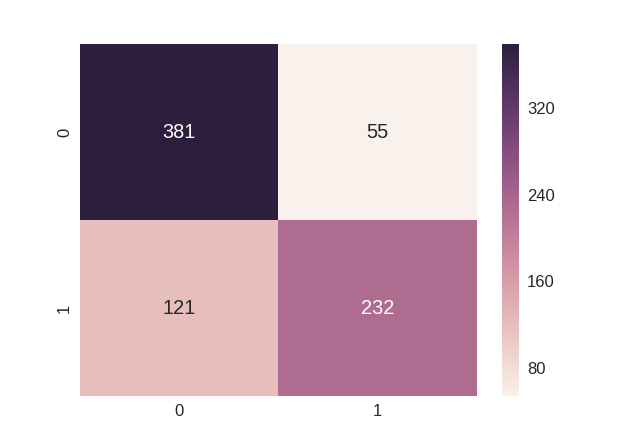

In [40]:
# Let's plot the confusion matrix so it's a little clearer
plt.figure()
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(y_test, gbc.predict(X_test)), annot=True, fmt='d')

## Let's look at the most important features in this model

In [41]:
gbcRankedFeatures = sorted(zip(X.columns, gbc.feature_importances_), 
                          key=lambda pair: pair[1], 
                          reverse=False)

<IPython.core.display.Javascript object>


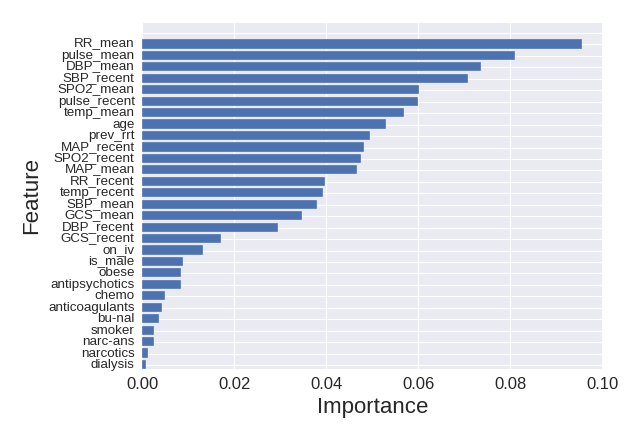

In [47]:
plt.figure()
make_feature_importance_plot(gbcRankedFeatures, 29)
plt.tight_layout()

### Let's look a partial dependence plots
#### If the partial dependence is high, then the model for that given value of that given feature is more likely to predict an rrt result.
#### Will not show more complex interactions -- if importance is high but partial dependence is marginal, this may be due to interactions

<IPython.core.display.Javascript object>


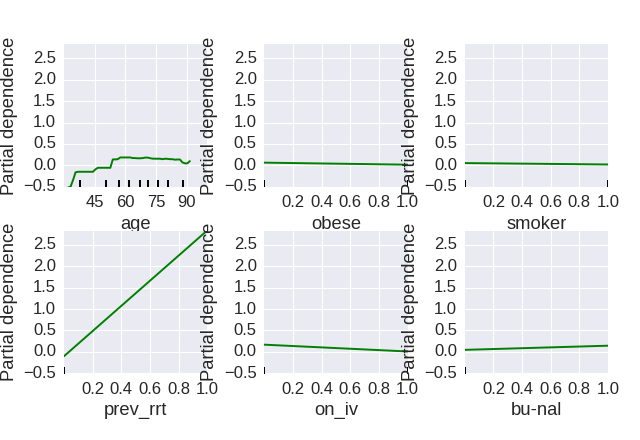

In [48]:
fig, axs = plot_partial_dependence(gbc, X_train, range(0, 6, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


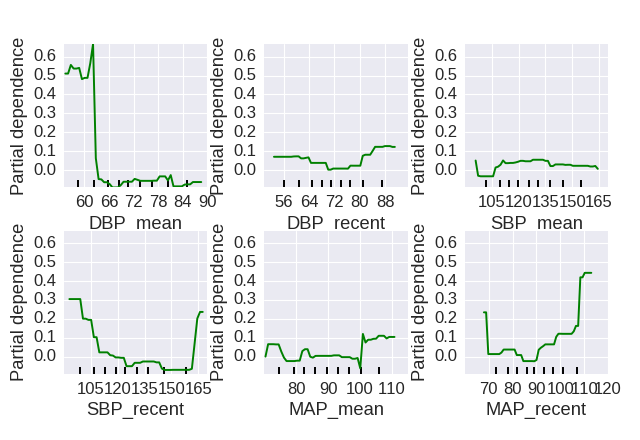

In [49]:
fig, axs = plot_partial_dependence(gbc, X_train, range(6, 12, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


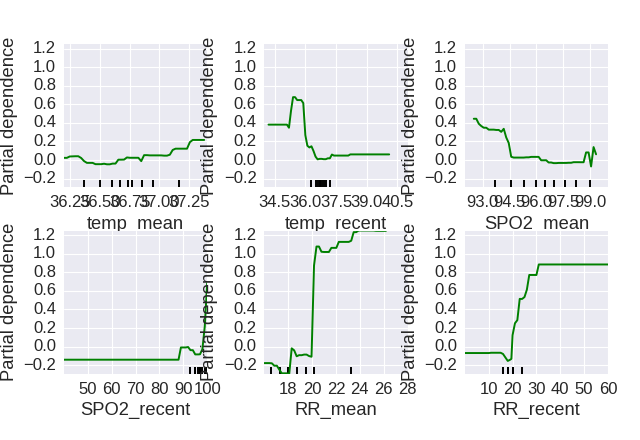

In [50]:
fig, axs = plot_partial_dependence(gbc, X_train, range(12, 18, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


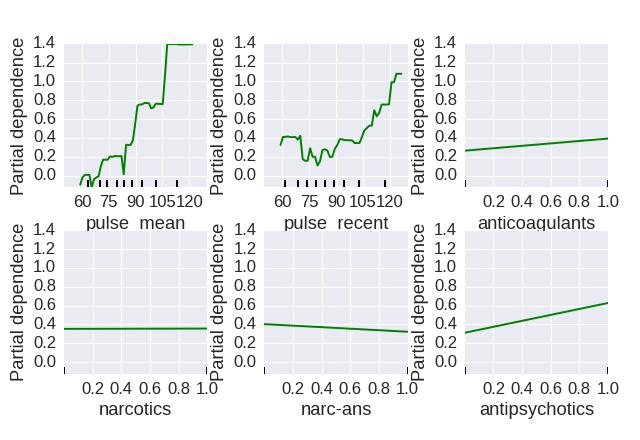

In [57]:
fig, axs = plot_partial_dependence(gbc, X_train, range(18, 24, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


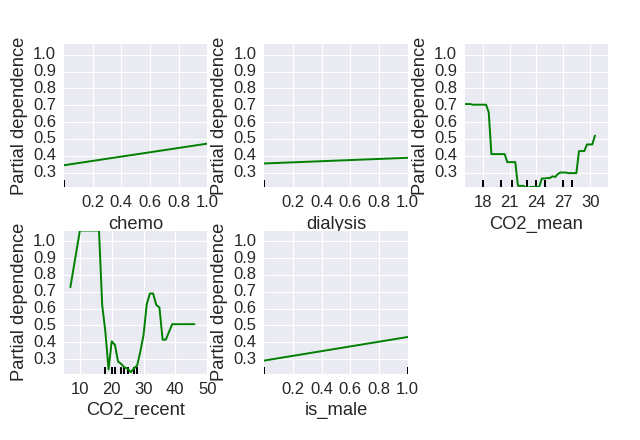

In [58]:
fig, axs = plot_partial_dependence(gbc, X_train, range(24, 29, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

## Use 3-D plot to investigate feature interactions for weak partial dependence plots... (weak effect may be masked by stronger interaction with other features)

In [51]:
names = X_train.columns
zip(range(len(names)), names)

[(0, 'age'),
 (1, 'obese'),
 (2, 'smoker'),
 (3, 'prev_rrt'),
 (4, 'on_iv'),
 (5, 'bu-nal'),
 (6, 'DBP_mean'),
 (7, 'DBP_recent'),
 (8, 'SBP_mean'),
 (9, 'SBP_recent'),
 (10, 'MAP_mean'),
 (11, 'MAP_recent'),
 (12, 'temp_mean'),
 (13, 'temp_recent'),
 (14, 'SPO2_mean'),
 (15, 'SPO2_recent'),
 (16, 'RR_mean'),
 (17, 'RR_recent'),
 (18, 'pulse_mean'),
 (19, 'pulse_recent'),
 (20, 'anticoagulants'),
 (21, 'narcotics'),
 (22, 'narc-ans'),
 (23, 'antipsychotics'),
 (24, 'chemo'),
 (25, 'dialysis'),
 (26, 'GCS_mean'),
 (27, 'GCS_recent'),
 (28, 'is_male')]

In [52]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


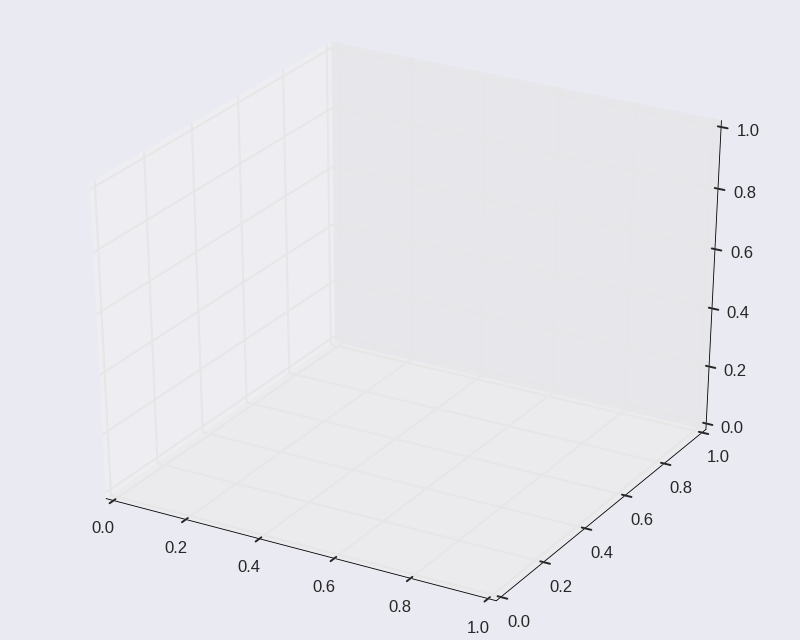

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [53]:
# not all features may work for this viz
fig = plt.figure(figsize=(10,8))
target_feature = (0, 26)  # <--  change the two numbers here to determine what to plot up
pdp, (x_axis, y_axis) = partial_dependence(gbc, target_feature, X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('')
plt.subplots_adjust(top=0.9)

plt.show()

In [54]:
# Return probabilities from the model, rather than predictions
y_proba = gbc.predict_proba(X_test)


pred_probs = pd.DataFrame(data=y_proba[:,1], columns =["model_probability_of_rrt"], index = X_test.index)


In [55]:
pred_probs['model_probability_of_rrt'] = pd.to_numeric(pred_probs.model_probability_of_rrt)

<IPython.core.display.Javascript object>


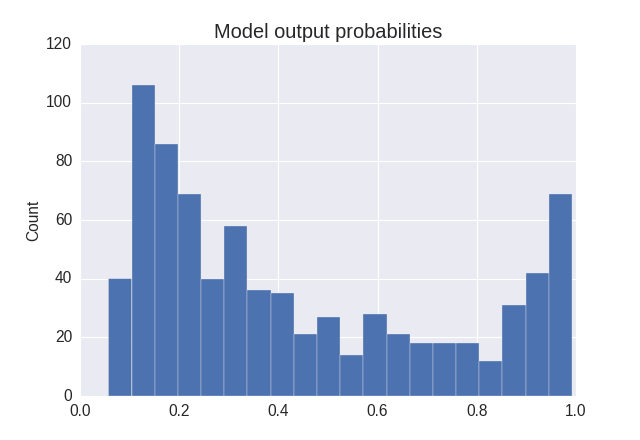

In [56]:
pred_probs.hist(bins = 20, xlabelsize = 16, ylabelsize=16)
plt.tick_params(labelsize=14)
plt.title("Model output probabilities")
plt.ylabel('Count', fontsize=14)

### We see that although we see more values close to 0 and 1, we also see that the model outputs a full range of probabilities, which would translate well into risk scores.


### Patient Risk Score = model probability * 10
The score should be rounded to whole values to give the sense that this is not an exact measure.

In [72]:
pred_probs['score'] = pred_probs['model_probability_of_rrt'].apply(lambda x: int(round(x*10.0, 0)))

In [73]:
pred_probs.head()

,model_probability_of_rrt,score
642,0.567736,6
1353,0.783027,8
792,0.205082,2
480,0.989041,10
1470,0.478017,5


In [74]:
pred_probs.score.value_counts()

10    111
9      68
2      56
1      56
3      47
5      38
8      34
4      34
7      27
6      24
0       3
Name: score, dtype: int64

### save out model

In [65]:
# from sklearn.externals import joblib
# # # joblib.dump(gbc, 'gbc_base.pkl') # note - if left uncompressed, this writes a whole lot of supporting numpy files.
# joblib.dump(gbc, 'gbc_base.compressed', compress=True)  

# # to unpack: joblib.load(filename)

['gbc_base.compressed']

In [418]:
## May need to rename columns to get rid of dash in name...
# df.rename(columns={'bu-nal': 'bu_nal', 'narc-ans': 'narc_ans'}, inplace=True)